In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Data Loading and Initial Preprocessing

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Project/1. Forecast/household_power_consumption.csv")

In [ ]:
df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])
df = df.set_index("timestamp")
df = df.sort_index()

/tmp/ipython-input-2797048051.py:1: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time"])


## Data Aggregation and Missing Value Handling

In [ ]:
numeric_cols = [
    "Global_active_power",
    "Global_reactive_power",
    "Voltage",
    "Global_intensity",
    "Sub_metering_1",
    "Sub_metering_2",
    "Sub_metering_3"
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")

# ---- Hourly Aggregation (mean per hour) ----
df_hourly = df["Global_active_power"].resample("H").mean()

# ---- Handle missing hours ----
df_hourly = df_hourly.interpolate()

print("Hourly series shape:", df_hourly.shape)

Hourly series shape: (17477,)


/tmp/ipython-input-1775646764.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_hourly = df["Global_active_power"].resample("H").mean()


## Train/Test Split

In [ ]:
train_size = int(len(df_hourly) * 0.8)
train = df_hourly.iloc[:train_size]
test  = df_hourly.iloc[train_size:]

print("Train points:", len(train))
print("Test points:", len(test))

Train points: 13981
Test points: 3496


## Prophet Model Initialization and Training

In [ ]:
train_prophet = train.reset_index()
train_prophet.columns = ["ds", "y"]

test_prophet = test.reset_index()
test_prophet.columns = ["ds", "y"]

In [ ]:
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    changepoint_prior_scale=0.5
)

In [ ]:
model.fit(train_prophet)

## Prophet Model Prediction

In [ ]:
future = test_prophet[["ds"]]
forecast = model.predict(future)

In [ ]:
prophet_pred = forecast["yhat"].values
prophet_predictions = pd.Series(prophet_pred, index=test.index)

## Model Evaluation

In [ ]:
mae  = mean_absolute_error(test, prophet_predictions)
rmse = np.sqrt(mean_squared_error(test, prophet_predictions))
mape = (abs((test - prophet_predictions) / test).mean()) * 100
smape = (2 * np.mean(np.abs(prophet_predictions - test) /
        (np.abs(test) + np.abs(prophet_predictions)))) * 100

print("\nProphet Model Performance (Hourly)")
print(f"MAE  : {mae:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAPE : {mape:.2f}%")
print(f"sMAPE: {smape:.2f}%")


Prophet Model Performance (Hourly)
MAE  : 0.7375
RMSE : 0.9772
MAPE : 123.99%
sMAPE: 102.40%


## Visualization

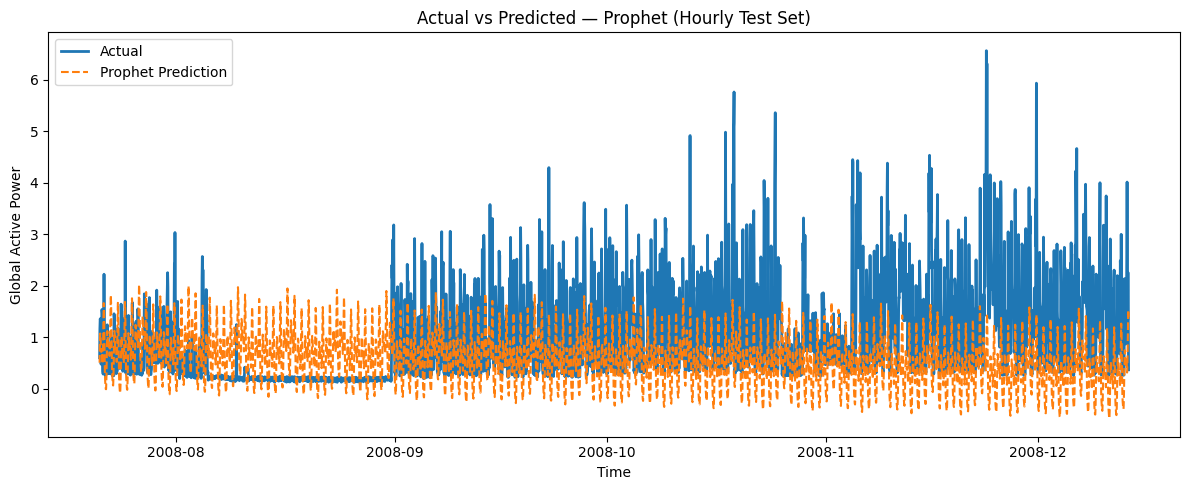

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(test, label="Actual", linewidth=2)
plt.plot(prophet_predictions, label="Prophet Prediction", linestyle="--")

plt.title("Actual vs Predicted — Prophet (Hourly Test Set)")
plt.xlabel("Time")
plt.ylabel("Global Active Power")
plt.legend()
plt.tight_layout()
plt.show()

## Display Results

In [ ]:
prophet_results_df = pd.DataFrame({
    "Actual": test,
    "Prophet_Prediction": prophet_predictions
})

prophet_results_df.head()

,Actual,Prophet_Prediction
timestamp,,
2008-07-21 06:00:00,0.601167,0.505334
2008-07-21 07:00:00,1.161033,0.868441
2008-07-21 08:00:00,1.356633,1.071216
2008-07-21 09:00:00,1.332733,1.032447
2008-07-21 10:00:00,0.669400,0.854524
